주제 : 환경을 분석해 사람에게 도움이 되는 모델 생성

구성 : 
1. 사진 데이터 수집
2. 사진 데이터 전처리
3. 데이터셋 구성
4. 데이터로더 구성
5. 모델 구성
6. 모델 학습
7. 모델 평가
8. 모델 저장 및 불러오기
9. 모델 예측
10. 프로젝트 정리

개인 주제 : 뱀의 독성 확인

1. 이미지 로드 확인

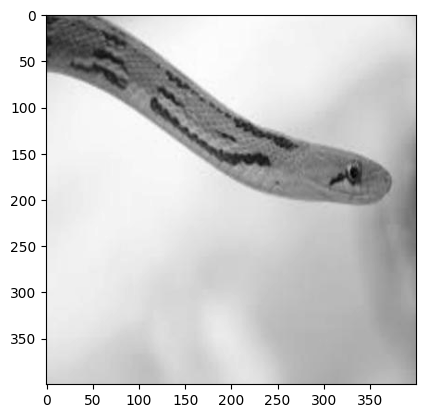

In [39]:
# 이미지 불러오기 : cv2.imread()
# 이미지 보여주기 : cv2.imshow()

import cv2
import matplotlib.pyplot as plt
import os
import cv2

# 이미지 폴더를 불러오기
# Folder path
folder_path = 'Snake Images/train/Non Venomous'

# 폴더 내 파일의 이름을 리스트로 저장
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Load and process each image : 인덱스로 불러오기
image_path = os.path.join(folder_path, image_files[0])  # 이미지 경로
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # 이미지 흑백으로 불러오기

# # for문 예시
# for image in image_files:
#     image_path = os.path.join(folder_path, image)
#     img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # 이미지 흑백으로 불러오기

# 이미지 출력
img_np = img.squeeze()
plt.imshow(img_np, cmap='gray')

In [52]:
# 모든 하위 폴더의 이미지 확인하기
file_folder = 'Snake Images/train'
for folder in os.listdir(file_folder):  # 폴더 내 파일의 이름을 리스트로 저장
    for file in os.listdir(os.path.join(file_folder, folder)):  # 폴더 내 파일의 이름을 리스트로 저장
        image_path = os.path.join(file_folder, folder, file)    # 이미지 경로
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # 이미지 흑백으로 불러오기
        img_np = img.squeeze()  # 이미지 출력
        plt.imshow(img_np, cmap='gray') 
        plt.show()

2. DataSet

In [111]:
# dataset class 만들기
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset

class SnakeDataset(Dataset):
    def __init__(self, folder_path):
        super(SnakeDataset, self).__init__()
        self.folder_path = folder_path
        self.image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        # 폴더 이름이 venomous이면 1, non-venomous이면 0
        self.labels = [0 if 'Non' in folder_path else 1 for _ in range(len(self.image_files))]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.folder_path, self.image_files[idx])
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        label = self.labels[idx]
        return torch.FloatTensor(img).reshape(1, -1), torch.tensor(label)

In [112]:
SnakeDataset(folder_path).__getitem__(0)

(tensor([[ 90.,  91.,  96.,  ..., 173., 173., 173.]]), tensor(0))

In [113]:
SnakeDataset(folder_path)[0][0]     # 인덱싱 테스트

tensor([[ 90.,  91.,  96.,  ..., 173., 173., 173.]])

<hr>
2-2. Set DataSet
 <hr>

In [129]:
# train folder 열기
path_tr_non = 'Snake Images/train/Non Venomous'
dataset_non = SnakeDataset(path_tr_non)
path_tr_ven = 'Snake Images/train/Venomous'
dataset_ven = SnakeDataset(path_tr_ven)

print(dataset_ven[0][1], dataset_non[0][1])  # 라벨링 테스트
# 길이
print(len(dataset_ven), len(dataset_non))   # 정확도를 사용하기엔 비율이 10:7

tensor(1) tensor(0)
1058 712


In [115]:
# non, ven 합치고 섞기
dataset_tr = dataset_non + dataset_ven
len(dataset_tr)

1770

3. DataLoader

3-1. Parameter Collection

In [116]:
# Collect all of parameters
BATCH_SIZE = 8

In [117]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# 1) Define Split
def split_dataset(dataset, split_ratio=0.8):
    seed = torch.Generator().manual_seed(11)
    train_ds, val_ds = random_split(dataset, [split_ratio, 1-split_ratio], generator=seed)
    return train_ds, val_ds

# 2) Define DataLoader
def get_dataloader(dataset, batch_size=32):
    return DataLoader(dataset, batch_size, shuffle=True)

# 3) Split / DataLoader
train_ds, val_ds = split_dataset(dataset_tr)
train_dl, val_dl = get_dataloader(train_ds, BATCH_SIZE), get_dataloader(val_ds, BATCH_SIZE)

# 4) Check the length of DataLoader
len(train_ds), len(val_ds), len(train_dl), len(val_dl)

(1417, 353, 178, 45)

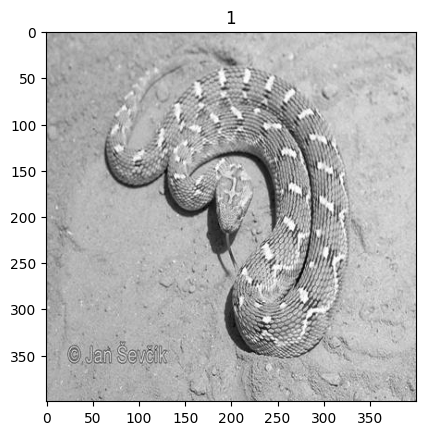

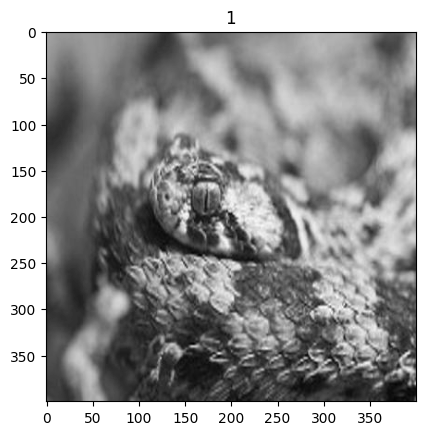

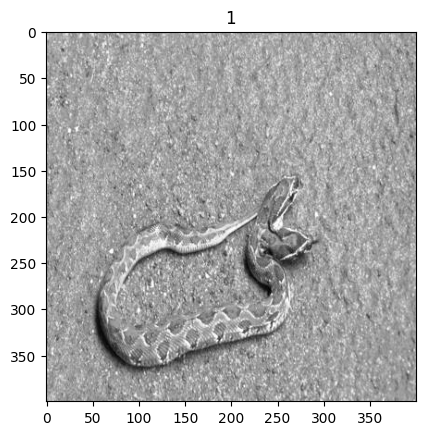

In [121]:
# train_dl 원소 확인 : img 출력
for img, label in train_dl:
    # 3개의 이미지 출력
    for i in range(3):
        plt.imshow(img[i].reshape(400, 400), cmap='gray')
        plt.title(label[i].item())
        plt.show()
    break

4. Model

In [119]:
import torch.nn as nn
import torch.nn.functional as F

# 모델 만들기
# - hidden layer : len(Hidden_list)-1 개
class ClassifyModel(nn.Module):
    def __init__(self, IN, Hidden_list, OUT):
        """분류 위한 심층 학습 모델

        Args:
            IN (int): 입력 피처 수
            Hidden_list (list): 은닉층 노드 수 리스트
            OUT (int): 출력 노드 수 
        """
        super(ClassifyModel, self).__init__()
        self.input_layer = nn.Linear(IN, Hidden_list[0])
        self.Hidden = nn.ModuleList([nn.Linear(Hidden_list[i], Hidden_list[i+1]) for i in range(len(Hidden_list)-1)])
        self.output_layer = nn.Linear(Hidden_list[-1], OUT)
        
    def forward(self, x):
        """모델의 forward 연산 정의

        Args:
            x (torch.Tensor): 입력 데이터

        Returns:
            torch.Tensor: 모델의 출력
        """
        x = F.relu(self.input_layer(x))
        for layer in self.Hidden:
            x = F.relu(layer(x))
        x = self.output_layer(x)
        return x

In [120]:
# 모델 테스트
IN = 100
Hidden_list = [32, 16]
OUT = 1
model_test = ClassifyModel(IN, Hidden_list, OUT)
model_test(torch.randn(8, 100))

tensor([[0.0567],
        [0.1123],
        [0.1008],
        [0.0821],
        [0.1515],
        [0.1190],
        [0.1360],
        [0.1886]], grad_fn=<AddmmBackward0>)

5. Training

In [125]:
# dataset_tr의 입력 피처 수
dataset_tr[0][0]

tensor([[ 90.,  91.,  96.,  ..., 173., 173., 173.]])

5-1. 파라미터 및 손실함수, 최적화함수, 스케쥴러 정의

In [130]:
# 1) Parameters
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IN, Hidden_list, OUT = 400*400, [1024, 512, 256, 128], 1
EPOCHS = 10

# 2) 모델 정의
model = ClassifyModel(IN, Hidden_list, OUT).to(DEVICE)

# 3) opitimizer 정의 : Adam
# - 이유 : Adam이 SGD보다 빠르게 수렴
import torch.optim as optim

LEARNING_RATE = 0.001
OPTIMIZER = optim.Adam(model_test.parameters(), lr=LEARNING_RATE)

# 4) Loss function 정의
# - CrossEntropyLoss vs BCELoss
# - 이유 : BCELoss는 binary classification에 사용, CrossEntropyLoss는 multi-class classification에 사용
#          BCELoss는 sigmoid 함수를 사용, CrossEntropyLoss는 softmax 함수를 사용
LF_BCE = nn.BCEWithLogitsLoss().to(DEVICE)
LF_CE = nn.CrossEntropyLoss().to(DEVICE)

# 5) Scheduler 정의
# - StepLR vs ReduceLROnPlateau
# - 이유 : StepLR은 step_size마다 learning rate를 감소시킴
#          ReduceLROnPlateau는 validation loss가 더이상 감소하지 않을 때 learning rate를 감소시킴
#         StepLR은 학습 초기에 사용, ReduceLROnPlateau는 학습 후반에 사용
STEP_SIZE = 5
GAMMA = 0.1
MODE = 'min'
PATIENCE = 3

SCHD_ST = optim.lr_scheduler.StepLR(OPTIMIZER, step_size=STEP_SIZE, gamma=GAMMA)
SCHD_RP = optim.lr_scheduler.ReduceLROnPlateau(OPTIMIZER, mode=MODE, patience=PATIENCE, verbose='auto')
# verbose 역할 : True이면 감소시킬 때마다 출력, False이면 감소시킬 때마다 출력하지 않음

# 6) 성능평가 지표 정의
# - Accuracy vs F1-score
# - 이유 : Accuracy는 불균형 데이터에 적합하지 않음
#          F1-score는 불균형 데이터에 적합 => F1-score 사용
from sklearn.metrics import f1_score


c:\Users\wjs31\anaconda3\envs\Torch_PY38\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


5-2. 학습

In [136]:
train_dl.dataset[0][0].shape, train_dl.dataset[0][1].shape

(torch.Size([1, 160000]), torch.Size([]))

In [132]:
def training(DL, model, LF, OPTIMIZER, DEVICE):
    model.train()
    train_loss, f1_scores, corrects, total = [], [], 0, 0
    for cnt, (img, label) in enumerate(DL):
        img, label = img.to(DEVICE), label.to(DEVICE)
        label = label.squeeze() # label의 차원을 1로 변경
        
        
        OPTIMIZER.zero_grad()   # optimizer 초기화
        
        preds = model(img)          # 모델 예측
        loss = LF(preds, label)     # loss 계산
        train_loss.append(loss.item())  # loss 누적        
        
        loss.backward()   # loss 역전파
        OPTIMIZER.step()  # optimizer 업데이트
        
        correct = [1 if preds[i] > 0.5 else 0 for i in range(len(preds))]  # 정확도 계산
        f1 = f1_score(label.numpy(), correct, average='binary') # 이진분류이므로 binary
        
        corrects += sum(correct)
        total += len(label)
        
        if cnt % 10 == 0:
            print(f'{cnt}/{len(DL)}')
        
    loss_score = train_loss / len(DL)
    accuracy = correct / total
    return loss_score, accuracy

In [133]:

training(train_dl, model, LF_BCE, OPTIMIZER, DEVICE)

ValueError: Target size (torch.Size([8])) must be the same as input size (torch.Size([8, 1, 1]))

6. Testing

7. Evaluation

8. Prediction

9. Save Model